### Submission Instructions

Just fill in the markdown and code cells below with your arguments and functions, and run the Python lines given. Make sure the notebook works fine by executing `Kernel/Restart & Run All`.
  
Once the notebook is ready,
1. Create a folder named `ftdl_last_name1_last_name2` with the team's last names.

2. Put in that folder:

* a file `mp_ftdl_last_name1_last_name2.ipynb` with the cells below completed. Make sure it works by executing Kernel/Restart & Run All.
* a file `mp_ftdl_last_name1_last_name2.html` with an html rendering of the previous .ipynb file (just apply File / Download as HTML after a correct run of Kernel/Restart & Run All).
* a file `mp_ftdl_last_name1_last_name2.pdf` with a pdf print of the html file **without any code**.

3. Compress the folder to a `ftdl_last_name1_last_name2.7z` 7z (or zip) file.

**Very important!!!**

Make sure you follow the file naming conventions above; the miniproject won't be graded until that is so.

## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

**IMPORTANT AND JUST IN CASE: before turning in your work, please REMOVE FROM IT THE PREVIOUS TWO CELLS**

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Wind Energy Prediction
We want to predict the wind energy production on a farm using wind speed and direction information.

The aim of this wind power forecasting problem is to predict the wind power generation 24 h ahead for a wind farm in Australia.

Attribute Information:
The features include forecasts of the projections of the wind vector on the west-east (U) and south-north (V) axes,at two heights, 10 and 100 m above ground level, plus the corresponding absolute wind speeds.

Data for a 10 month period are given in a csv file with headers

`TIMESTAMP,TARGETVAR,U10,V10,U100,V100,v10,v100`

where

* TIMESTAMP contains day/hour information.
* TARGETVAR is the wind energy production normalized to a [0, 100] range.
* U10,V10,U100,V100 are the U and V wind components in m/s at heights 10 and 100.
* v10,v100 are the absolute wind speeds in m/s at heights 10 and 100.

The dataset we will use is an adaptation of those available in the Kaggle page https://www.kaggle.com/c/GEF2012-wind-forecasting. 

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

In [4]:
start_time = time.time()

## Data Loading

The dataset is preloaded in the sciki-learn library. As it is shown in the next output the dataset contains 6576 observations and 7 variables, including the target.

In [5]:
df_0 = pd.read_csv('.\w_e.csv', index_col=0, parse_dates=True)
l_vars = df_0.columns[1 : ]
print(l_vars)
df = df_0[l_vars]
df['target'] = df_0['TARGETVAR']

print ("nFilas: %d\tnColumnas: %d\n" % (df.shape[0], df.shape[1]) )
print ("Columnas:\t", np.array(df.columns))

Index(['U10', 'V10', 'U100', 'V100', 'v10', 'v100'], dtype='object')
nFilas: 6576	nColumnas: 7

Columnas:	 ['U10' 'V10' 'U100' 'V100' 'v10' 'v100' 'target']


# Data Exploration, Visualization and Correlations

In this section, we will present a descriptive analysis over the entire dataset to know the nature of data.

* Compute descriptive statistics.
* Draw boxplots, pairplots and histograms.
* Compute and present correlations. 

#TODO: Give your comments and conclusions after each step.

## Descriptive analysis

We first showed a sample of data that allows us to know the format of data. We can see that data can be seen as a timeseries, because each observation belongs to a different instant time. 

In [6]:
df.head()

,U10,V10,U100,V100,v10,v100,target
TIMESTAMP,,,,,,,
2012-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000
2012-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,5.487912
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400
2012-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,16.511606
2012-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,15.694013


In the next cell, we show a descriptive analysis of all variables in the dataset. The count suggests that there are not missing values in our dataset because all variables have the same number of values. In addition, the quartiles metrics show that there is no rextremely rare values and value ranges appear to be reasonable.

In [7]:
df.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
U10,6576.0,0.93,2.55,-7.49,-1.09,0.78,2.48,11.12
V10,6576.0,-0.25,2.99,-9.99,-2.38,0.01,1.96,9.07
U100,6576.0,1.59,4.25,-10.91,-1.77,1.41,4.64,16.99
V100,6576.0,-0.48,5.13,-15.29,-4.80,0.30,3.61,14.31
v10,6576.0,3.63,1.78,0.12,2.20,3.33,4.79,11.74
v100,6576.0,6.33,2.65,0.08,4.43,6.18,8.00,18.49
target,6576.0,30.99,29.57,0.00,5.83,21.36,50.16,99.95


## Boxplots

Next, we are going to check the existence of outliers in each of the variables using boxplots. The data has been normalized in order to have uniform ranges in the graphics.

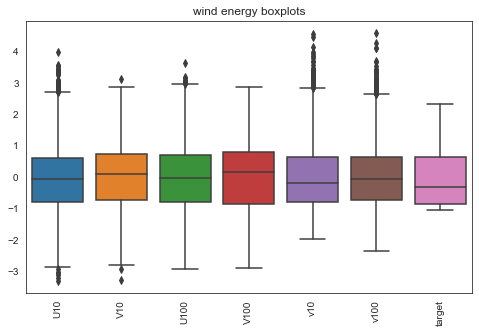

In [8]:
df_normalized = (df - df.mean()) / df.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_normalized)
plt.title("wind energy boxplots")
plt.xticks(rotation=90)
plt.show()

As we can see in the figure above, the variables *v10* and *v100* are the ones with more outliers, points past the main lines.

## Histograms and scatterplots

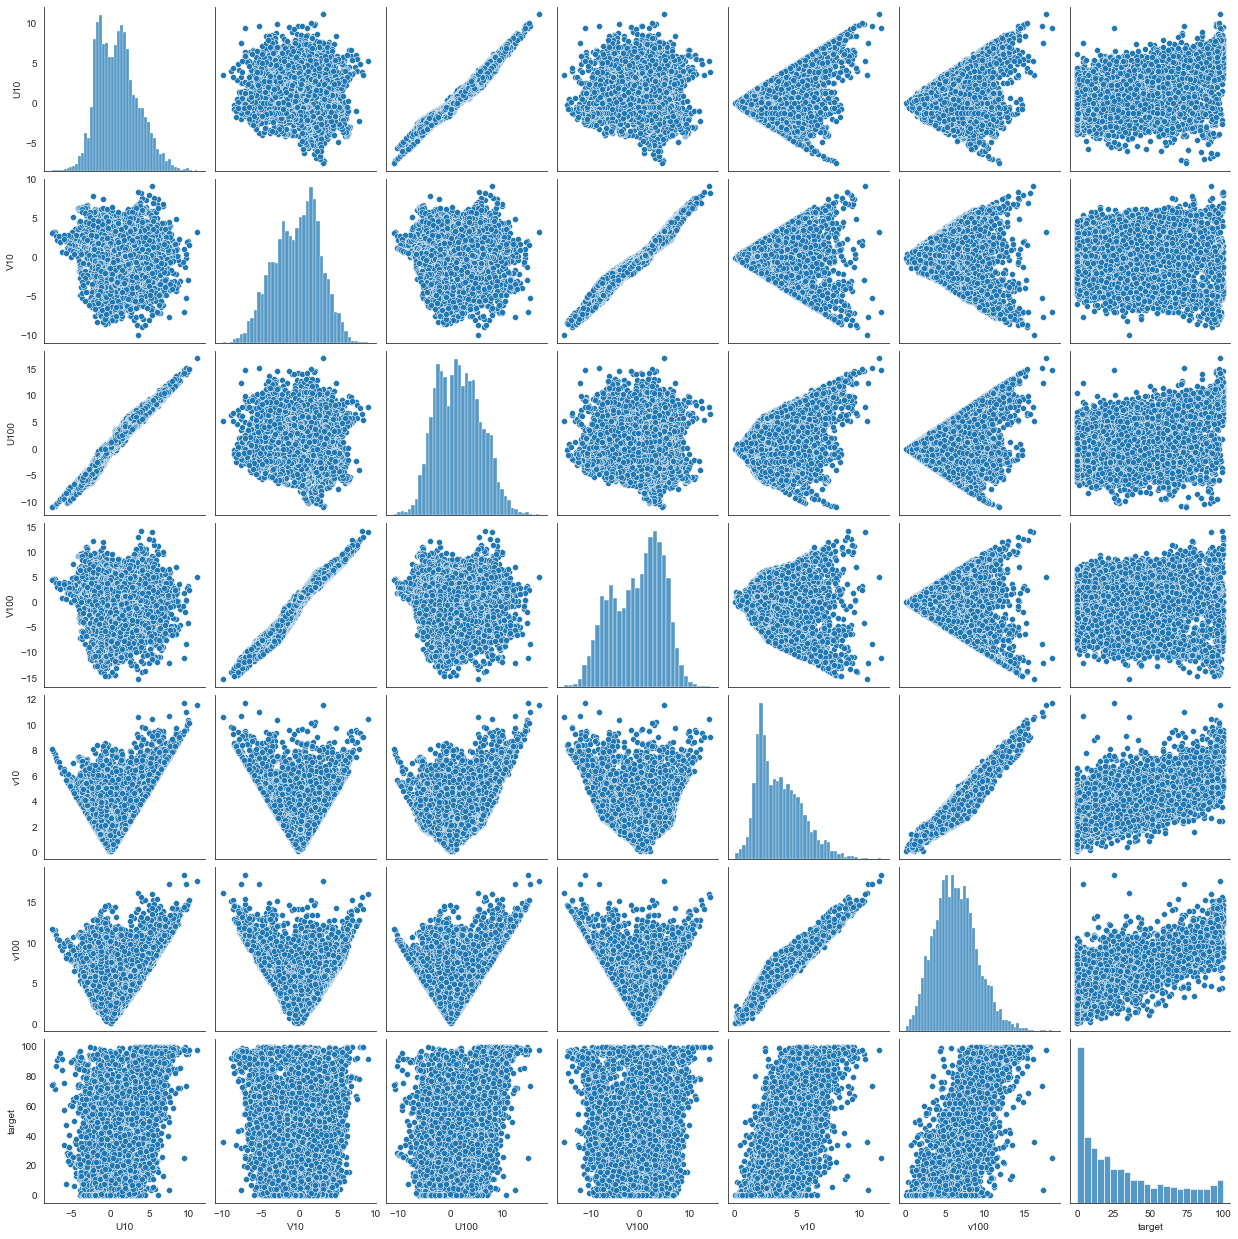

In [9]:
num_vars_to_show = 6 
pair_plot = sns.pairplot(df[list(l_vars)[:num_vars_to_show] + ['target']])
plt.show()

It seems that there are no variables which have a linear relationship with the target. However, there is a clearly linear relationship bethween some of the variables. For intance, between v10 and v100

## Correlations

Next, it is shown the correlation matrix which helps us determine the variables that are linearly correlated. As it was said before, the variable *v10* and *v100* are highly correlated. 

In [10]:
df.corr().round(decimals=3)

,U10,V10,U100,V100,v10,v100,target
U10,1.000,-0.098,0.981,-0.058,0.441,0.392,0.377
V10,-0.098,1.000,-0.133,0.981,-0.162,-0.257,-0.166
U100,0.981,-0.133,1.000,-0.095,0.394,0.364,0.365
V100,-0.058,0.981,-0.095,1.000,-0.172,-0.279,-0.177
v10,0.441,-0.162,0.394,-0.172,1.000,0.915,0.706
v100,0.392,-0.257,0.364,-0.279,0.915,1.000,0.745
target,0.377,-0.166,0.365,-0.177,0.706,0.745,1.000


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

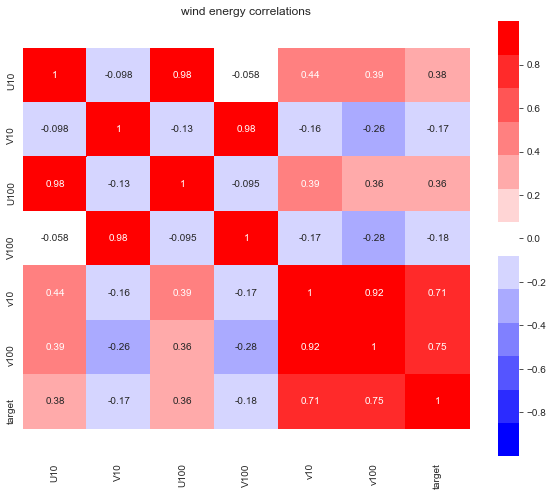

In [12]:
n_colors = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

fig = plt.figure( figsize=(10, 8))
plt.title('wind energy correlations')
h_map = sns.heatmap(df.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(df.columns),
                    yticklabels=list(df.columns))
plt.xticks(rotation=90) 

cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

## Overall conclusions

In [13]:
# TODO highly correlated variables... It would be ... to eliminate one of the correlated variables because 

# Poner la parte de que no es invertible si hay variables altamente correlacionadas

# MLPRegressor

Perform a CV MLPR estimation of a pipelined MLPR over three folds over the entire sample.

We perform a CV MLPRegressor using GridSearch to optimize hyperparameters. Initially, we selected as optimizable params the alpha, the hidden layer sizes and the maximum number of iterations. A first search was executed taking into account these three parameters, however, it was seen that the maximum number of iterations do not has a direct impact on results and it delayed the training stage, so we decide to fix it to 10000 iterations, which was the best hyperparameter found, and re-executed the search algorithm taking into account just the other two: alpha and hidden layer size. 

In [14]:
sc = StandardScaler()

x = sc.fit_transform(df[l_vars])
y = df[['target']]

In [15]:
#USAMOS KFOLD CV
n_folds = 3
kf = KFold(n_folds, shuffle=False)

mlpr_kf =  MLPRegressor(activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=10000)

regr_kf = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr_kf)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr_kf,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {
    'regressor__mlp__alpha': l_alpha, 
    'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]    
}

cv_mlp = GridSearchCV(inner_estimator, 
                    param_grid=param_grid, 
                    cv=kf, 
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    refit=True,
                    n_jobs=-1, 
                    verbose=1)

t_0 = time.time()
cv_mlp.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f_name = 'mlp_search_results_kf.joblib'
joblib.dump(cv_mlp, f_name, compress=3)

Fitting 3 folds for each of 39 candidates, totalling 117 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed: 13.3min finished



mlp_grid_search_time: 13.37


['mlp_search_results_kf.joblib']

## Analyzing GridSearchCV results

In this section the results of the the GridSearchCV are analyzed in function of the mean absolute error (mae). 
The possible params values are listed below and also, the params which conducted to the model with the lowest error. The alpha selected was 10.00 and (20, 20) as hidden layers size.

Check the adequacy of the best hyperparameters.

In [17]:
cv_mlp = joblib.load('mlp_search_results_kf.joblib')

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_mlp.best_params_['regressor__mlp__alpha']))
print('----------')

print(f"layer_sizes = {[(20,), (20, 20), (20, 20, 20)]}" )
best_size = cv_mlp.best_params_['regressor__mlp__hidden_layer_sizes']
print(f'best_hidden_layer_sizes = {best_size}')
print('----------')

# print(f"max_iter range: 1000 - 100000")
# best_max_iter = cv_mlp.best_params_['regressor__mlp__max_iter']
# print(f"best max_iter = {best_max_iter}")
# print('----------')

print('best_cv_mae = %.3f' % (-cv_mlp.best_score_))

alpha_range: 0.00 - 1000000.00
best_alpha = 10.00
----------
layer_sizes = [(20,), (20, 20), (20, 20, 20)]
best_hidden_layer_sizes = (20, 20)
----------
best_cv_mae = 13.411


The table below shows the five configurations which reached the highest performance during GridSearch. It can be seen that the best model reached an score

In [18]:
mlp_search = pd.DataFrame.from_dict(cv_mlp.cv_results_)
mlp_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__mlp__alpha',\
                                                                      'param_regressor__mlp__hidden_layer_sizes',\
                                                                      'mean_test_score',
                                                                       'mean_train_score']][:5]

,param_regressor__mlp__alpha,param_regressor__mlp__hidden_layer_sizes,mean_test_score,mean_train_score
22,10,"(20, 20)",-13.411034,-11.937412
23,10,"(20, 20, 20)",-13.470577,-11.774539
21,10,"(20,)",-13.521571,-12.325513
18,1,"(20,)",-13.745684,-11.668445
0,1e-06,"(20,)",-13.814739,-11.505747


In the following graphic we plot the errors with respect to *alpha*. It can be seen that while the higher the alpha, also increments the absolute error. 

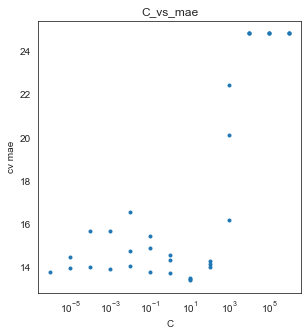

In [19]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot(mlp_search['param_regressor__mlp__alpha'], -mlp_search['mean_test_score'], '.')

In [20]:
# plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
# _ = plt.plot(-cv_mlp.cv_results_['mean_test_score'])

## Testing the MLPR model

Do it over the entire dataset using `cross_val_predict`, get the CV MAE and draw the appropriate plots.

We test the model over the entire dataset using the function `cross_val_predict`. In addtion, we plot the predicted and the real values and calculate the MAE.

In [21]:
y_pred_mlp_cv = np.clip(cross_val_predict(cv_mlp.best_estimator_, x, y, cv=kf, n_jobs=-1), 0., 200.)

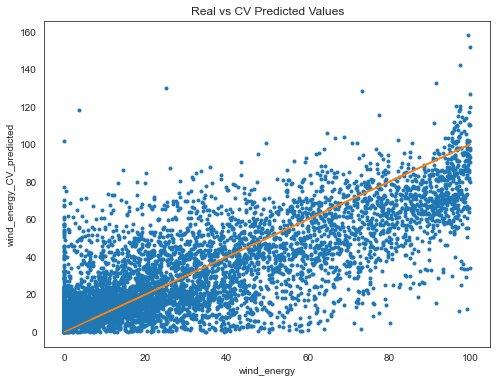

In [22]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

In [23]:
from sklearn.metrics import mean_absolute_error

print("MAE: %.3f" % mean_absolute_error(y, y_pred_mlp_cv))

MAE: 13.642


## MLP Residual histograms and relationship with targets

Show and discuss them.

In this section we show two graphics related to the model errors. In the first one we show the error distribution and in the second one the real values agains the erros in each of the observation in the dataset.

mae: 13.642


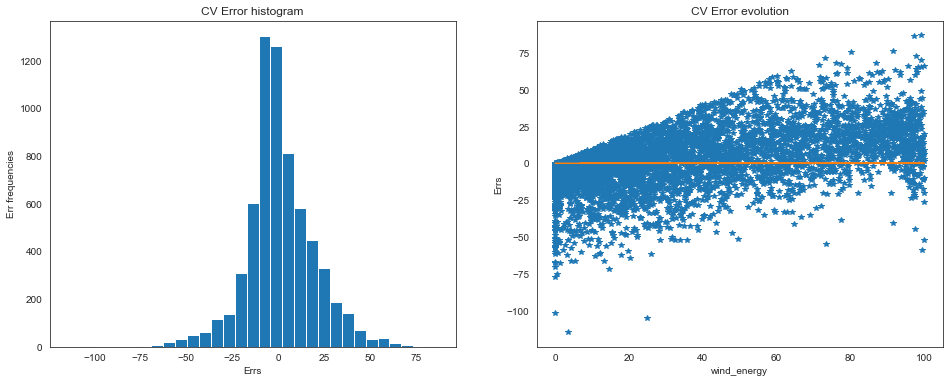

In [24]:
err = y - y_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

The first graphic shows that errors have mean close to cero, but they do not look normally distributed. There are more observations with positive error than negative which means that in most of the cases the predicted value is below the real one. This translated to natural language, means that most of the time the model predicts greater wind energy thet the real one. On the other hand, the second graphic shows that the model is more exact in values close to the media, however, in extremes values, high or small, the model gets a greater error, which means that the model gets wrong in high and small wind ebergy values. This figure also shows that there are more points above the zero line than below, confirming what express the histogram.

# SV Regressor

This section is dedicated to the SV Regressor. We will be training a SV regresors with gaussian kernels, reason why we have to set hyperparameters `C, gamma` and the `epsilon` insensitivity. We perform a GridSearchCV to find the parameters which best fit models. As we are going to optimize three values, the search space increases considerably so we need to downsample the original data to values every three hours, making the dataset smaller.

In the next output we show a sample of the reduced data.

In [25]:
sample_df = df.resample('3H').first()
sample_df.head(10)

,U10,V10,U100,V100,v10,v100,target
TIMESTAMP,,,,,,,
2012-01-01 00:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400
2012-01-01 06:00:00,1.986038,0.796304,2.655406,0.882648,2.139730,2.798258,16.878113
2012-01-01 09:00:00,-1.380191,2.903624,-3.048145,6.041520,3.214959,6.766916,15.318109
2012-01-01 12:00:00,-2.340389,0.617855,-6.095209,1.564929,2.420571,6.292899,14.782445
2012-01-01 15:00:00,-2.020323,-0.455396,-5.185562,-1.845935,2.071012,5.504319,24.104877
2012-01-01 18:00:00,-0.234062,-3.575916,0.028920,-8.864540,3.583568,8.864587,25.345362
2012-01-01 21:00:00,0.431304,-3.920464,1.175177,-8.187682,3.944117,8.271588,73.545717
2012-01-02 00:00:00,1.468088,-5.200273,2.254640,-7.688174,5.403529,8.011955,76.045483


After reducing, the new dataset have 2193 observations with the same 6 variables.

In [26]:
x_sample = sample_df[l_vars].values
y_sample = sample_df[['target']].values.reshape(-1,)
num_patterns, dim = x_sample.shape
num_patterns, dim

(2193, 6)

In [27]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

sv = GridSearchCV(inner_estimator, 
                    param_grid=param_grid, 
                    cv=kf, 
                    scoring='neg_mean_absolute_error', 
                    refit=True,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1)

t_0 = time.time()
sv.fit(x_sample, y_sample)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("sv_search_results.pkz", 'wb') 
pickle.dump(sv, f_pkl)
f_pkl.close()

num_hyperparams 378
Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.7s


grid_search_time: 501.348635 segundos


[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  8.4min finished


In [28]:
f_pkl = open("sv_search_results.pkz", 'rb') 
sv = pickle.load(f_pkl)
f_pkl.close()

Next, the considered values of selected hyperparams are listed and also, the ones which got the best performance.

In [29]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", sv.best_params_['regressor__svr__C']) 
print('--------')

print("gamma_range: %.5f - %.5f" % (np.array(l_gamma).min(), np.array(l_gamma).max()))
print("\tbest_gamma:", sv.best_params_['regressor__svr__gamma'])
print('--------')

print("epsilon_range: %.5f - %.3f" % (np.array(l_epsilon).min(), np.array(l_epsilon).max()))
print("\tbest_epsilon:", sv.best_params_['regressor__svr__epsilon'])
print('--------')

C_range: 0.0010 - 1000
	best_C: 1.0
--------
gamma_range: 0.04167 - 10.66667
	best_gamma: 5.333333333333333
--------
epsilon_range: 0.01562 - 0.500
	best_epsilon: 0.125
--------


The table below shows the the five configurations with the lower error sorted by performance. As we can see the best configuation reached a mae ove of ... over the test set.

In [30]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(sv.cv_results_)
df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                                      'param_regressor__svr__gamma',\
                                                                      'param_regressor__svr__epsilon',\
                                                                      'mean_test_score']][ : 5]

,param_regressor__svr__C,param_regressor__svr__gamma,param_regressor__svr__epsilon,mean_test_score
196,1,5.33333,0.125,-12.976252
169,1,5.33333,0.015625,-13.003942
249,10,2.66667,0.125,-13.019025
187,1,5.33333,0.0625,-13.019426
178,1,5.33333,0.03125,-13.023488


The next cell shows each of the hyperparameter in function of the error reached during training.

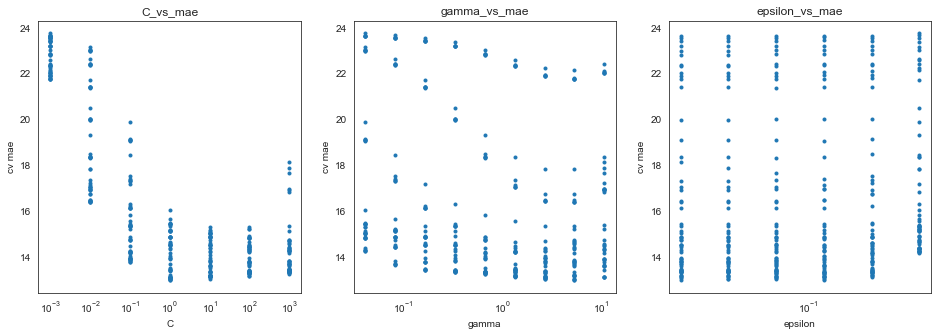

In [31]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
#plt.ylim(1.8, 2.2)
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

The first figure shows the `C` in functions of the error reached during training. It can be seen that ....#TODO. The second one shows the `gamma` against the error. This parametars is useful to ...#TODO. On the other hand the third graphic which shows the parameter `epsilon` suggests that this parameter does not has a great incfluence on model results because the mae do not shows great changes.

In [32]:
best_estimator = sv.best_estimator_

scores = cross_val_score(best_estimator, x_sample, y_sample, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 12.976		mae_std: 1.296


In [33]:
from sklearn.model_selection import cross_val_predict

y_pred_svr = np.clip(cross_val_predict(best_estimator, x_sample, y_sample, cv=kf, n_jobs=-1), 0., 200.)

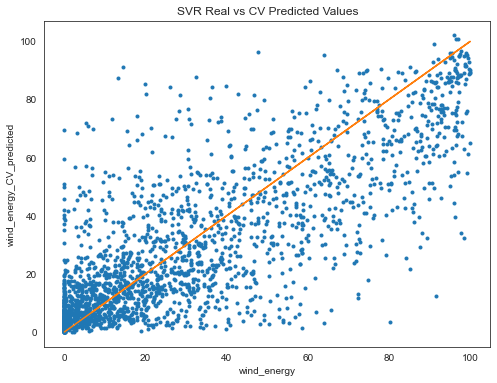

In [34]:
plt.figure( figsize=(8,6))

plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_sample, y_pred_svr, '.', y_sample, y_sample, '-')

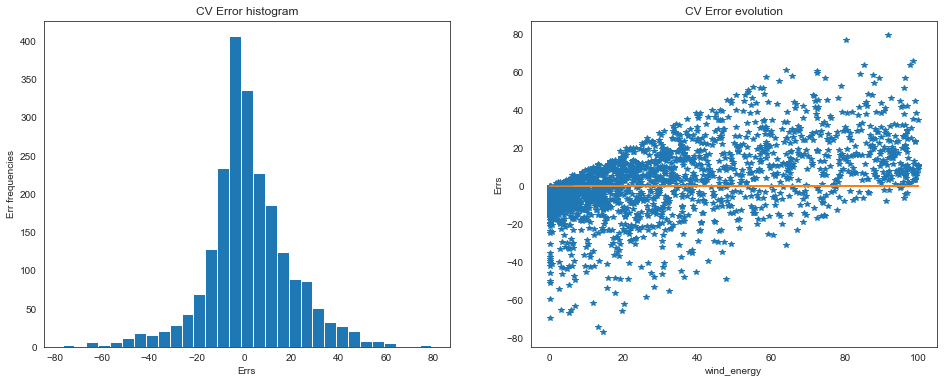

In [36]:
err = y_sample - y_pred_svr

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y_sample, err, '*', y, 0.*y, '-')

plt.show()

# MLPR and SVR comparison

Compare them and draw the appropriate conclusions.

In [37]:
print("mlpr_mae: {0:.3f}".format(mean_absolute_error(y, y_pred_mlp_cv)))
print("svr_mae: {0:.3f}".format(mean_absolute_error(y_sample, y_pred_svr)))

mlpr_mae: 13.642
svr_mae: 12.975


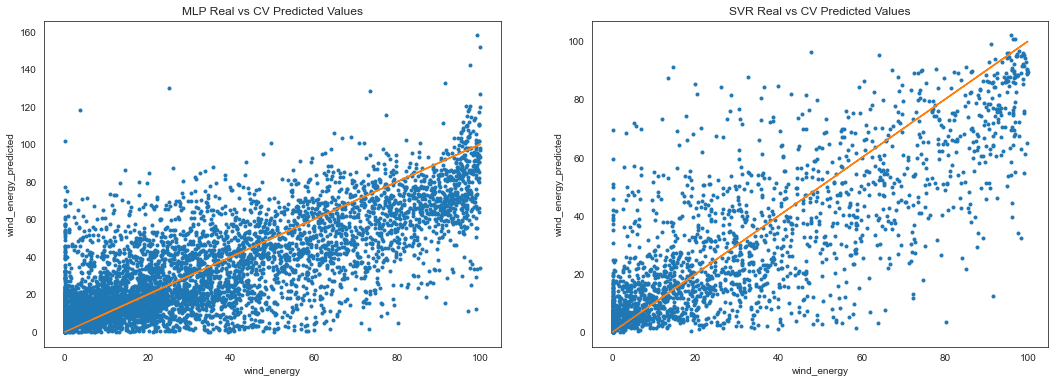

In [38]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.title('MLP Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

plt.subplot(1, 2, 2)
plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_predicted')
_ = plt.plot(y_sample, y_pred_svr, '.', y_sample, y_sample, '-')

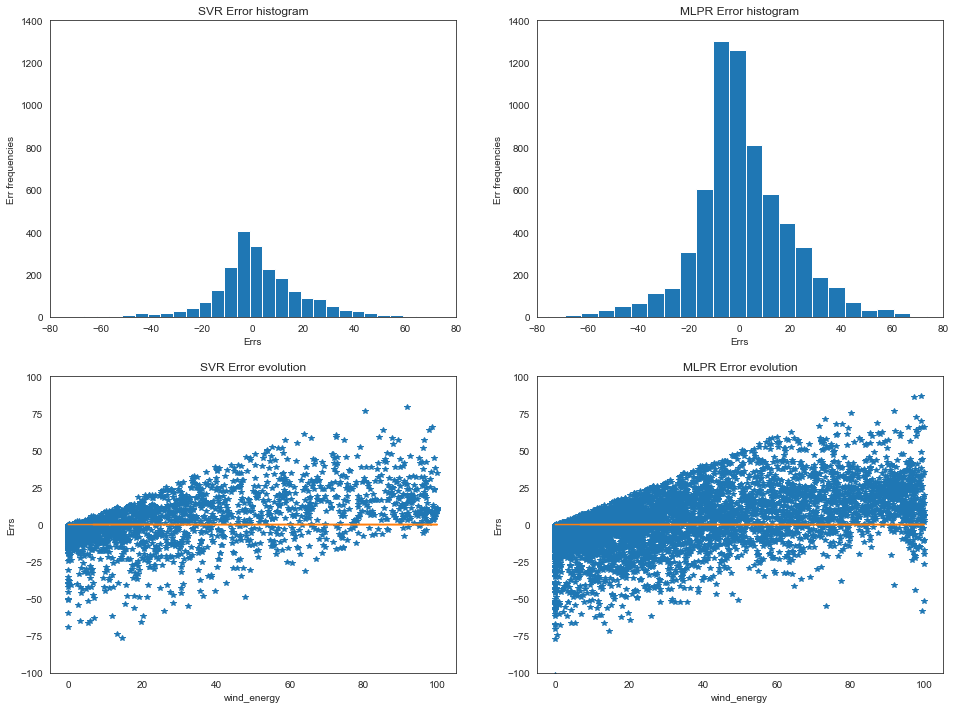

In [39]:
plt.figure( figsize=(16, 12))

plt.subplot(2, 2, 2)
plt.title("MLPR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-80, 80)
plt.ylim(0, 1400)
_ = plt.hist(y - y_pred_mlp_cv, bins=31)

plt.subplot(2, 2, 1)
plt.title("SVR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-80, 80)
plt.ylim(0, 1400)
_ = plt.hist(y_sample - y_pred_svr, bins=31)


plt.subplot(2, 2, 4)
plt.title("MLPR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y, y - y_pred_mlp_cv, '*', y, 0.*y, '-')


plt.subplot(2,2,3)
plt.title("SVR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y_sample, y_sample - y_pred_svr, '*', y, 0.*y, '-')

plt.show()

# Trying to improve the estimator

Me may try to improve the MLPR and SVR results by enlarging the features set with the square and cube powers of the absolute velocities.

Redo the previous MLPR and SVR analysis and conclusions over the enlarged dataset with the same analysis structure.

In [40]:
square_abs_vel_10 = df[['v10']]**2
square_abs_vel_100 = df[['v100']]**2
cube_abs_vel_10 = df[['v10']]**2
cube_abs_vel_100 = df[['v100']]**3

In [41]:
df_large = df
df_large[['sqr_v10']] = square_abs_vel_10
df_large[['sqr_v100']] = square_abs_vel_100
df_large[['cub_v10']] = cube_abs_vel_10
df_large[['cub_v100']] = cube_abs_vel_10

In [42]:
df_large.head()

,U10,V10,U100,V100,v10,v100,target,sqr_v10,sqr_v100,cub_v10,cub_v100
TIMESTAMP,,,,,,,,,,,
2012-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000,11.706869,21.644209,11.706869,11.706869
2012-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,5.487912,9.588009,17.263129,9.588009,9.588009
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400,7.817238,13.783229,7.817238,7.817238
2012-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,16.511606,6.059961,10.464133,6.059961,6.059961
2012-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,15.694013,5.195826,8.858551,5.195826,5.195826


In [43]:
x_large = df_large[list(l_vars) + ['sqr_v10', 'sqr_v100', 'cub_v10', 'sqr_v100']]
y_large = df_large[['target']]

## MLPR model over enlarged features

In [44]:
# select alpha in mlp regression by CV
n_folds = 3
kf = KFold(n_folds, shuffle=False)

mlpr =  MLPRegressor(activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=10000)

regr = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {'regressor__mlp__alpha': l_alpha,
             'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}  


cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x_large, y_large)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f_name = 'mlp_large_search_results.joblib'
joblib.dump(cv_estimator, f_name, compress=3)

Fitting 3 folds for each of 39 candidates, totalling 117 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed: 11.8min finished



mlp_grid_search_time: 11.79


['mlp_large_search_results.joblib']

In [45]:
cv_estimator = joblib.load('mlp_large_search_results.joblib')

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('----------')

print(f"layer_sizes = {[(20,), (20, 20), (20, 20, 20)]}" )
best_size = cv_estimator.best_params_['regressor__mlp__hidden_layer_sizes']
print(f'best_hidden_layer_sizes = {best_size}')
print('----------')

print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

alpha_range: 0.00 - 1000000.00
best_alpha = 10.00
----------
layer_sizes = [(20,), (20, 20), (20, 20, 20)]
best_hidden_layer_sizes = (20,)
----------
best_cv_mae = 13.381


In [46]:
sv_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
sv_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__mlp__alpha',\
                                                                      'param_regressor__mlp__hidden_layer_sizes',\
                                                                      'mean_test_score',
                                                                       'mean_train_score']][:5]

,param_regressor__mlp__alpha,param_regressor__mlp__hidden_layer_sizes,mean_test_score,mean_train_score
21,10,"(20,)",-13.380933,-12.087338
23,10,"(20, 20, 20)",-13.435870,-11.553711
22,10,"(20, 20)",-13.456010,-11.825710
18,1,"(20,)",-13.666948,-11.573618
15,0.1,"(20,)",-13.742618,-11.481015


In [47]:
# plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
# _ = plt.plot( -cv_estimator.cv_results_['mean_test_score'])

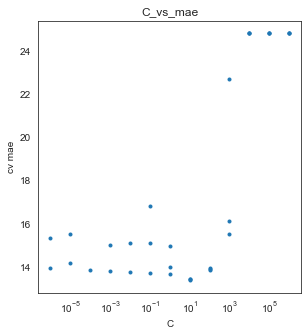

In [48]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot(sv_search['param_regressor__mlp__alpha'], -sv_search['mean_test_score'], '.')

In [49]:
y_large_pred_mlp_cv = np.clip( cross_val_predict(cv_estimator.best_estimator_, x_large, y_large, cv=kf, n_jobs=-1), 0., 200.)

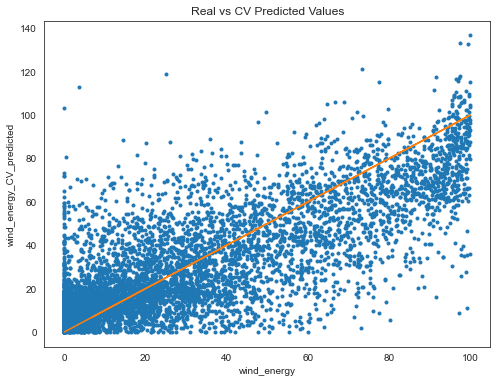

In [50]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_large, y_large_pred_mlp_cv, '.', y_large, y_large, '-')

mae: 13.518


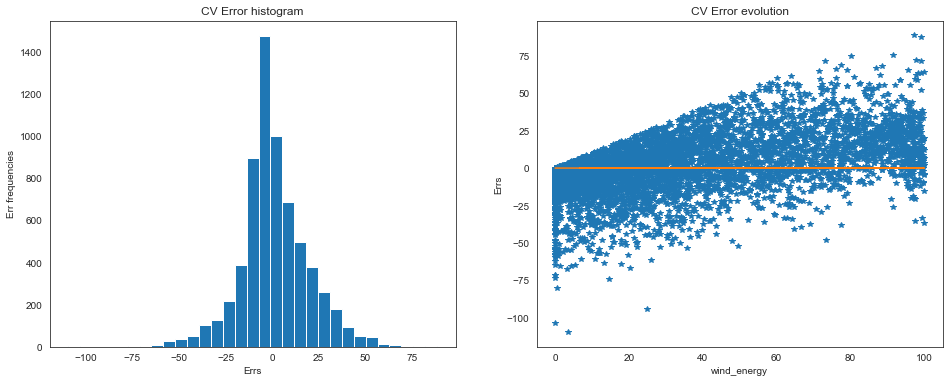

In [51]:
err = y_large - y_large_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y_large, err, '*', y_large, 0.*y_large, '-')

plt.show()

## Conclusions on the enlarged MLPR model

## SVR model over enlarged features


In [52]:
df_large_sample = df_large.resample('3H').first()
df_large_sample.head(10)

,U10,V10,U100,V100,v10,v100,target,sqr_v10,sqr_v100,cub_v10,cub_v100
TIMESTAMP,,,,,,,,,,,
2012-01-01 00:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000,11.706869,21.644209,11.706869,11.706869
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400,7.817238,13.783229,7.817238,7.817238
2012-01-01 06:00:00,1.986038,0.796304,2.655406,0.882648,2.139730,2.798258,16.878113,4.578446,7.830248,4.578446,4.578446
2012-01-01 09:00:00,-1.380191,2.903624,-3.048145,6.041520,3.214959,6.766916,15.318109,10.335960,45.791152,10.335960,10.335960
2012-01-01 12:00:00,-2.340389,0.617855,-6.095209,1.564929,2.420571,6.292899,14.782445,5.859165,39.600575,5.859165,5.859165
2012-01-01 15:00:00,-2.020323,-0.455396,-5.185562,-1.845935,2.071012,5.504319,24.104877,4.289090,30.297526,4.289090,4.289090
2012-01-01 18:00:00,-0.234062,-3.575916,0.028920,-8.864540,3.583568,8.864587,25.345362,12.841963,78.580900,12.841963,12.841963
2012-01-01 21:00:00,0.431304,-3.920464,1.175177,-8.187682,3.944117,8.271588,73.545717,15.556062,68.419174,15.556062,15.556062
2012-01-02 00:00:00,1.468088,-5.200273,2.254640,-7.688174,5.403529,8.011955,76.045483,29.198127,64.191418,29.198127,29.198127


In [53]:
l_vars_lg = list(l_vars) + ['sqr_v10', 'sqr_v100', 'cub_v10', 'sqr_v100']
x_large_sample = df_large_sample[l_vars_lg].values
y_large_sample = df_large_sample[['target']].values.reshape(-1,)
num_patterns, dim = x_large_sample.shape
num_patterns, dim

(2193, 10)

In [54]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error', 
                            refit=True,
                            n_jobs=-1,
                            return_train_score=True,
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x_large_sample, y_large_sample)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("c_gamma_epsilon_cv_search_energy_wind_large.pkz", 'wb') 
pickle.dump(cv_estimator, f_pkl)
f_pkl.close()

num_hyperparams 378
Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  7.3min finished


grid_search_time: 439.409036 segundos


In [55]:
f_pkl = open("c_gamma_epsilon_cv_search_energy_wind_large.pkz", 'rb') 
cv_estimator = pickle.load(f_pkl)
f_pkl.close()

In [56]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", cv_estimator.best_params_['regressor__svr__C']) 

print("gamma_range: %.5f - %.5f" % (np.array(l_gamma).min(), np.array(l_gamma).max()))
print("\tbest_gamma:", cv_estimator.best_params_['regressor__svr__gamma'])

print("epsilon_range: %.5f - %.3f" % (np.array(l_epsilon).min(), np.array(l_epsilon).max()))
print("\tbest_epsilon:", cv_estimator.best_params_['regressor__svr__epsilon'])

C_range: 0.0010 - 1000
	best_C: 1.0
gamma_range: 0.02500 - 6.40000
	best_gamma: 3.2
epsilon_range: 0.01562 - 0.500
	best_epsilon: 0.015625


In [57]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                                      'param_regressor__svr__gamma',\
                                                                      'param_regressor__svr__epsilon',\
                                                                      'mean_test_score']][ : 5]

,param_regressor__svr__C,param_regressor__svr__gamma,param_regressor__svr__epsilon,mean_test_score
169,1,3.2,0.015625,-13.005909
196,1,3.2,0.125,-13.033131
178,1,3.2,0.03125,-13.038662
187,1,3.2,0.0625,-13.040796
249,10,1.6,0.125,-13.062384


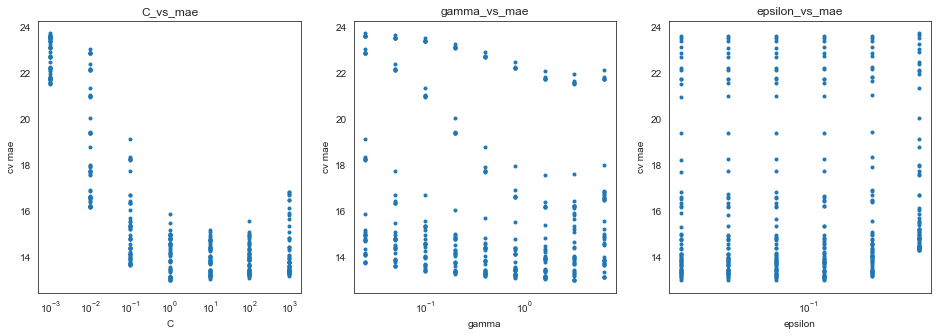

In [58]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
#plt.ylim(1.8, 2.2)
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

In [59]:
best_estimator = cv_estimator.best_estimator_

scores = cross_val_score(best_estimator, x_large_sample,y_large_sample, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 13.006		mae_std: 1.514


In [60]:
y_large_pred_svr = np.clip( cross_val_predict(best_estimator,  x_large_sample, y_large_sample, cv=kf, n_jobs=-1), 0., 200.)

print("mae: {0:.3f}".format(mean_absolute_error( y_large_sample, y_large_pred_svr)))

mae: 12.999


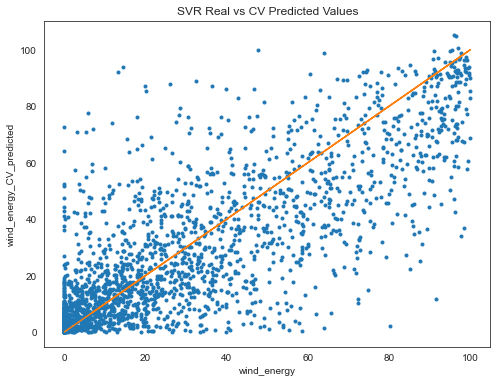

In [61]:
plt.figure( figsize=(8,6))

plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot( y_large_sample, y_large_pred_svr, '.', y_large_sample, y_large_sample, '-')

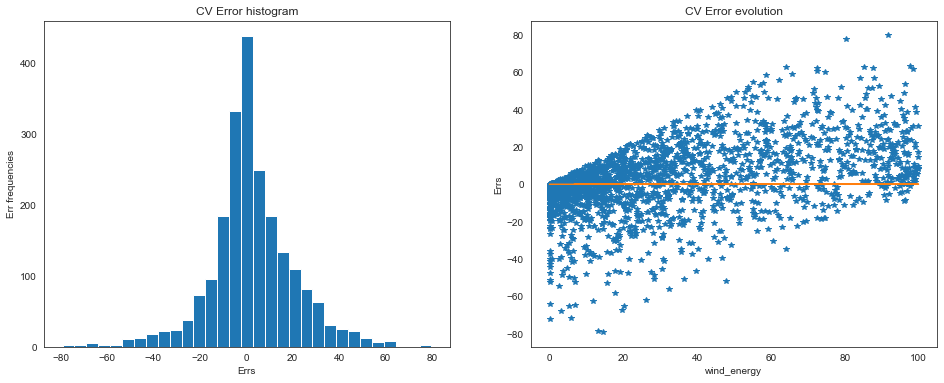

In [62]:
err =  y_large_sample - y_large_pred_svr

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y_large_sample, err, '*', y_large_sample, 0.*y_large_sample, '-')

plt.show()

In [63]:
print("mlpr_mae: {0:.3f}".format(mean_absolute_error(y_large, y_large_pred_mlp_cv)))
print("svr_mae: {0:.3f}".format(mean_absolute_error( y_large_sample, y_large_pred_svr)))

mlpr_mae: 13.518
svr_mae: 12.999


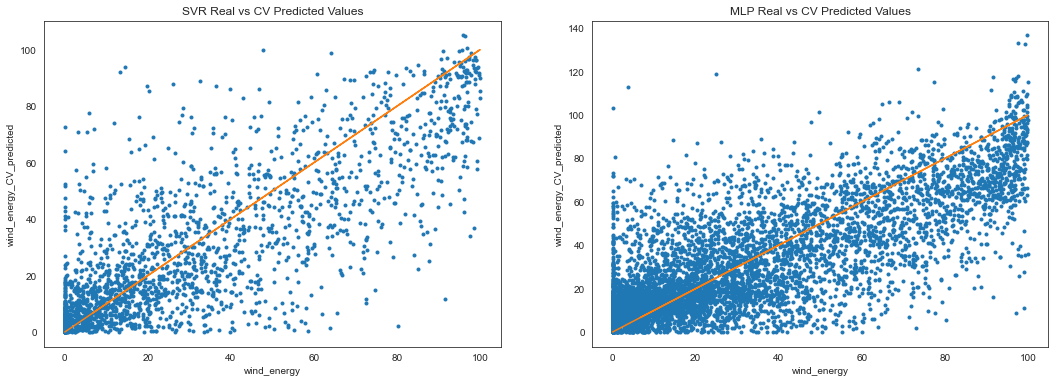

In [64]:
plt.figure( figsize=(18,6))

plt.subplot(1, 2, 1)
plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_large_sample, y_large_pred_svr, '.', y_large_sample, y_large_sample, '-')

plt.subplot(1, 2, 2)
plt.title('MLP Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_large, y_large_pred_mlp_cv, '.', y_large, y_large, '-')

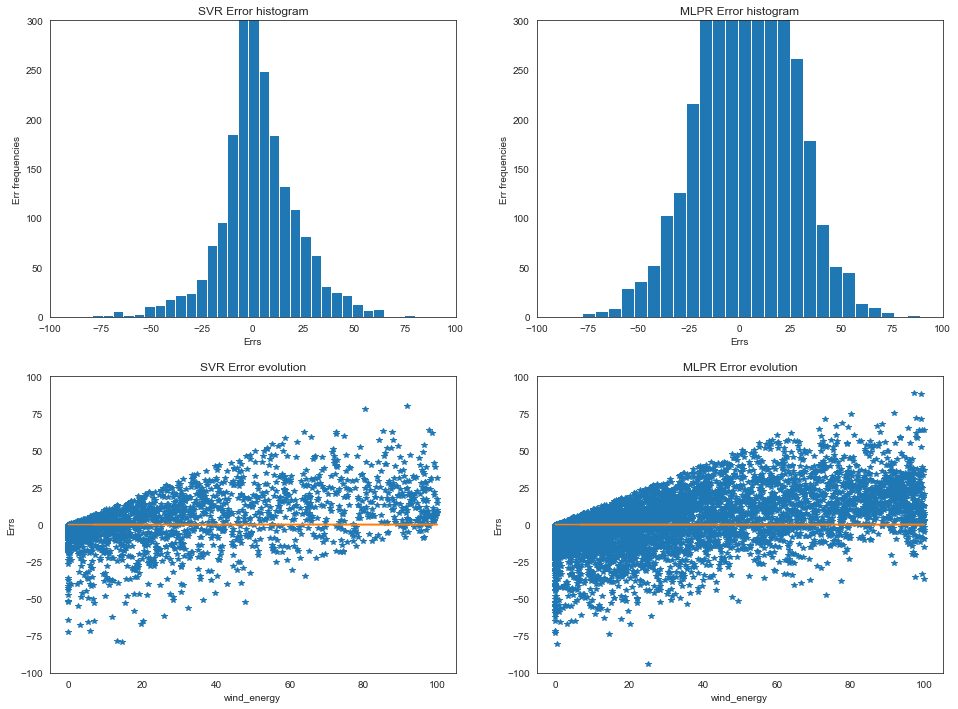

In [65]:
plt.figure( figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.title("SVR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-100, 100)
plt.ylim(0, 300)
_ = plt.hist(y_large_sample - y_large_pred_svr, bins=31)

plt.subplot(2, 2, 2)
plt.title("MLPR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-100, 100)
plt.ylim(0, 300)
_ = plt.hist(y_large - y_large_pred_mlp_cv, bins=31)

plt.subplot(2,2,3)
plt.title("SVR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y_large_sample, y_large_sample - y_large_pred_svr, '*', y_large_sample, 0.*y_large_sample, '-')

plt.subplot(2, 2, 4)
plt.title("MLPR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y_large, y_large - y_large_pred_mlp_cv, '*', y_large, 0.*y_large, '-')

plt.show()

## Conclusions on the enlarged SVR model

# Final conclusions

In [66]:
end_time = time.time()
print("\Total time: %.2f" % ((end_time - start_time)/60.))

\Total time: 44.84
